In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from groupy.gconv.tensorflow_gconv.splitgconv2d import gconv2d_util, gconv2d, gconv2d_addbias
from groupy.gfunc.z2func_array import Z2FuncArray
from groupy.gfunc.p4func_array import P4FuncArray
from groupy.gfunc.p4mfunc_array import P4MFuncArray
import groupy.garray.C4_array as C4a
import groupy.garray.D4_array as D4a

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [ ]:
file = mnist_all_rotation_normalized_float_train_valid.amat

f = open

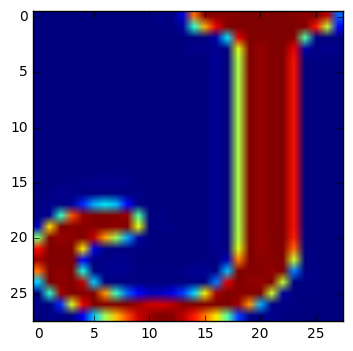

9


In [3]:
#example image
import matplotlib.pyplot as plt
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
imgnum = np.random.randint(len(train_labels))
imgplot = plt.imshow(train_dataset[imgnum])
plt.show()
print(train_labels[imgnum])

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


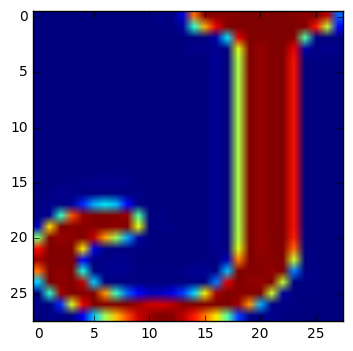

In [5]:
imgplot = plt.imshow(train_dataset[imgnum,...,0])
plt.show()

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [7]:
class gconv_layer():
    
    def __init__(self, gin, gout, in_channels, out_channels, ksize=3, max_pool=False, use_relu=True):
        self.gin = gin
        self.gout = gout
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.ksize = ksize
        self.max_pool = max_pool
        self.use_relu = use_relu
        self.conv = None
        self.relu = None
        self.conv_bias = None
        if self.use_relu:
            self.relu = None
        if self.max_pool:
            self.maxpool = None
        
        
    def __call__(self):
        self.gconv_indices, self.gconv_shape_info, self.w_shape = gconv2d_util(
            h_input=self.gin, h_output=self.gout, in_channels=self.in_channels, out_channels=self.out_channels,
            ksize=self.ksize )
        self.w = tf.Variable(tf.truncated_normal(self.w_shape, stddev=1.))
        self.b = tf.Variable(tf.zeros([self.out_channels]))
        
    def run_glayer(self, data, stride=[1, 1, 1, 1]):
        nti = self.gconv_shape_info[-2]
        nto = self.gconv_shape_info[1]
        
        self.conv = gconv2d(input=data, filter=self.w, strides=stride, padding='SAME',
            gconv_indices=self.gconv_indices, gconv_shape_info=self.gconv_shape_info)
        self.conv_bias = gconv2d_addbias(self.conv, self.b, nto)
        res = self.conv_bias
        
        if self.use_relu:
            self.relu = tf.nn.relu(self.conv_bias)
            res = self.relu
            
        if self.max_pool:
            self.maxpool =  tf.nn.max_pool(self.relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            res = self.maxpool
        
        return res

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Learning rate
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)

  # Dropout
  keep_prob = tf.placeholder(tf.float32)
    
  #layer 1 - simple Z2 --> P4 cov layer 
  gconv_l1 = gconv_layer(gin='Z2', gout='C4', in_channels=num_channels, out_channels=depth // 4)
  gconv_l1() #set vars

  #layer 2 - simple P4 --> P4 cov layer
  gconv_l2 = gconv_layer(gin='C4', gout='C4', in_channels=depth // 4, out_channels=depth // 4, ksize=3, max_pool=True)
  gconv_l2() #set vars
  
  #layer 3 - FC 
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size  * image_size * depth // 4, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
  #layer 4 - softmax
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  #Model
  def model(data):
    
    out_l1 = gconv_l1.run_glayer(data)
    out_l2 = gconv_l2.run_glayer(out_l1)
    
    shape = out_l2.get_shape().as_list()
    reshape = tf.reshape(out_l2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden_drop = tf.nn.dropout(hidden, keep_prob)
    return tf.matmul(hidden_drop, layer4_weights) + layer4_biases

  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [9]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 1}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(feed_dict={keep_prob : 1.0}), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(feed_dict={keep_prob : 1.0}), test_labels))

Initialized
Minibatch loss at step 0: 15.496178
Minibatch accuracy: 0.0%
Validation accuracy: 10.4%
Minibatch loss at step 50: 1.807947
Minibatch accuracy: 37.5%
Validation accuracy: 50.7%
Minibatch loss at step 100: 1.582008
Minibatch accuracy: 37.5%
Validation accuracy: 65.7%
Minibatch loss at step 150: 0.941495
Minibatch accuracy: 81.2%
Validation accuracy: 71.6%
Minibatch loss at step 200: 0.895284
Minibatch accuracy: 68.8%
Validation accuracy: 73.4%
Minibatch loss at step 250: 1.119801
Minibatch accuracy: 75.0%
Validation accuracy: 76.2%
Minibatch loss at step 300: 0.861068
Minibatch accuracy: 75.0%
Validation accuracy: 77.0%
Minibatch loss at step 350: 1.329424
Minibatch accuracy: 62.5%
Validation accuracy: 75.5%
Minibatch loss at step 400: 0.820592
Minibatch accuracy: 62.5%
Validation accuracy: 77.5%
Minibatch loss at step 450: 1.141325
Minibatch accuracy: 62.5%
Validation accuracy: 77.5%
Minibatch loss at step 500: 1.285291
Minibatch accuracy: 56.2%
Validation accuracy: 76.8%
M